### Coding Challange 

Thanks for your interest in Whisper.

Company lets it's **users explore message by categories**. These categories are automatically assigned to each message using Machine Learning. For this challenge we'd like you to implement a similar model.

We provide you with a dataset of message, which are *manually labeled with a category*. The dataset is in csv format and utf8 encoded. We are providing you with a baseline model. We are asking you to **experiment with potential improvements**. Our model is implemented in Python making use of scikit-learn. You are free to use any other programming language or tool you are familiar with, however you'll need to reproduce our model in that environment yourself. The evaluation metric that we are using is the **macro f1-score**.

You are free to try anything that you feel could potentially improve the performance. For instance: *unsupervised preprecessing, manually engineerd features, different models, recurrent neural networks, word vectors, ensemble of models*.

Please **provide us with the code for your experiments, even ones that failed**. **Document briefly what you are trying to do and why you think the experiment succeeded or failed**. Make sure your code in clean and readable. We are not mainly evaluating you by the performance of your model, but we are trying to get an understanding about how you think. **Be prepared to answer questions about your work, the problem at hand and evaluation**.

If you have any questions, please let us know.

In [1]:
# Imports
import pandas as pd
import numpy as np
import nltk

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read training and testing data
train = pd.read_csv('data/train.csv') # category, text
test = pd.read_csv('data/test.csv') # category, text

# Replace NaN with ''
train = train.fillna('')
test = test.fillna('')

In [3]:
# Check if # of categories in training set = # of categories in testing set
print train.groupby('category').count().reset_index().shape[0]
print test.groupby('category').count().reset_index().shape[0]

17
17


In [4]:
# Group by category
train.groupby('category').count().reset_index()

# NOTE: Looks like there is class imbalance
#       most texts are categorized as "meetup", "misc", "personal", "relationshps"

category  text
0         animals   147
1           faith    49
2          family   445
3         fashion   136
4            food   266
5           lgbtq   546
6          meetup  2942
7        military    45
8            misc  2718
9        personal  3559
10    pop_culture   519
11            qna   909
12  relationships  1159
13         school   263
14         sports    61
15         tatoos    85
16           work   199

### Baseline Model

In [5]:
%run baseline.py

macro f1: 0.323676828408


/Users/ankoorbhagat/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Data Exploration
- Wordcloud

In [6]:
# Imports
import string
from nltk.tokenize import RegexpTokenizer
from nltk import bigrams
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Function to clean text
def clean_text(text):
    '''
    Function to clean text and modify string
    Process: lowercase > remove punctuation > tokenize > stopword removal > join 
        Input: text string
        Output: cleaned and modified text string
    '''
    # Decode: utf-8
    text = text.decode('utf8')
    # RegExp tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # English stopwords
    en_stopwords = stopwords.words('english')
    # Convert text to lower case
    raw_text = text.lower()
    # Tokenize
    tokens = tokenizer.tokenize(raw_text)
    # Remove stopwords: English 
    tokens_remaining = [t for t in tokens if t not in en_stopwords]      
    # Combine the tokens
    cleaned_text = ' '.join(tokens_remaining)
    return cleaned_text

In [7]:
# Process text
num_text = train['text'].shape[0]
texts = []
for i in xrange(num_text):
    temp = clean_text(train['text'][i])
    texts.append(temp)

# Print first 3 messages
print texts[:3]

[u'looking someone hold conversation guy', u'hey', u'single guys girls near spalding female']


In [8]:
# tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf matrix
tfidf_vectorizer = TfidfVectorizer(max_features=1000) # top 1000 words
tfidf_features = tfidf_vectorizer.fit_transform(texts)
print tfidf_features.shape

(14048, 1000)


In [9]:
# Create Pandas dataframe
index = xrange(tfidf_features.shape[0])
cols = tfidf_vectorizer.get_feature_names()
tfidf_df = pd.DataFrame(data=tfidf_features.toarray(), index=index, columns=cols)
tfidf_df['category'] = train['category']

In [10]:
# Group by category and calculate mean
tfidf_grouped = tfidf_df.groupby(['category']).mean()
tfidf_group = tfidf_grouped.reset_index()

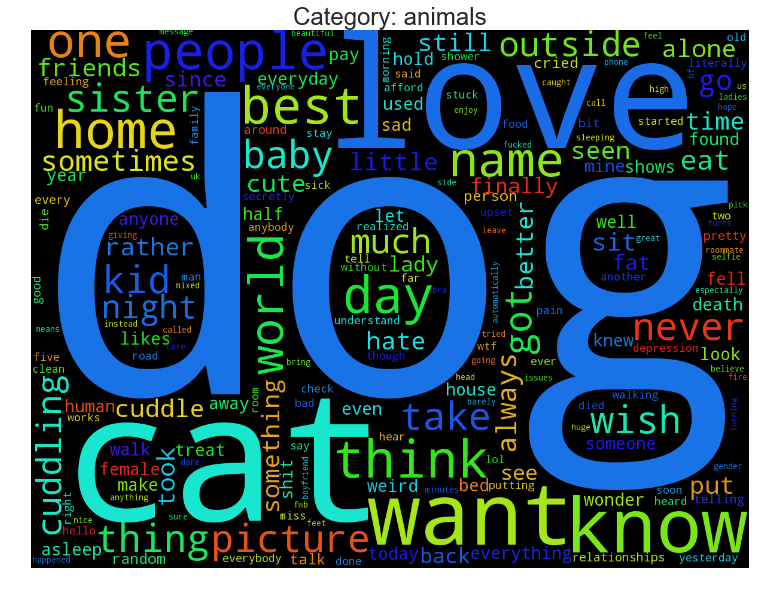

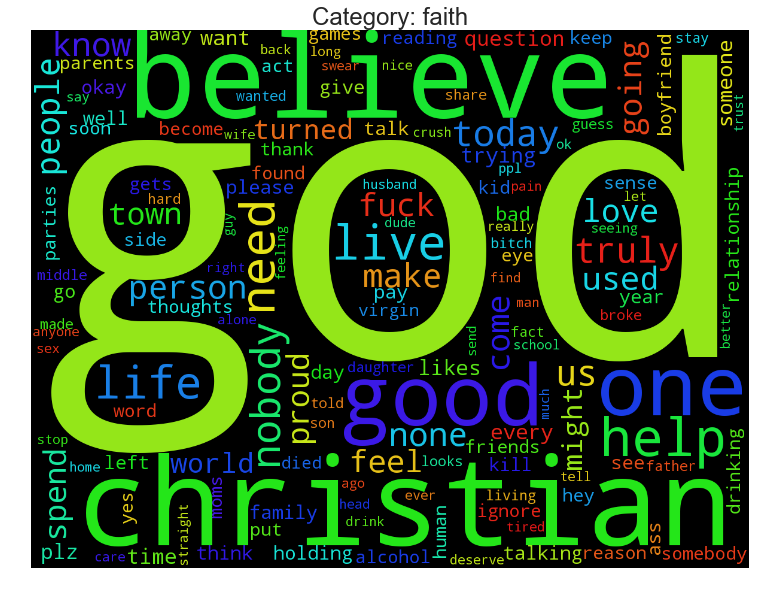

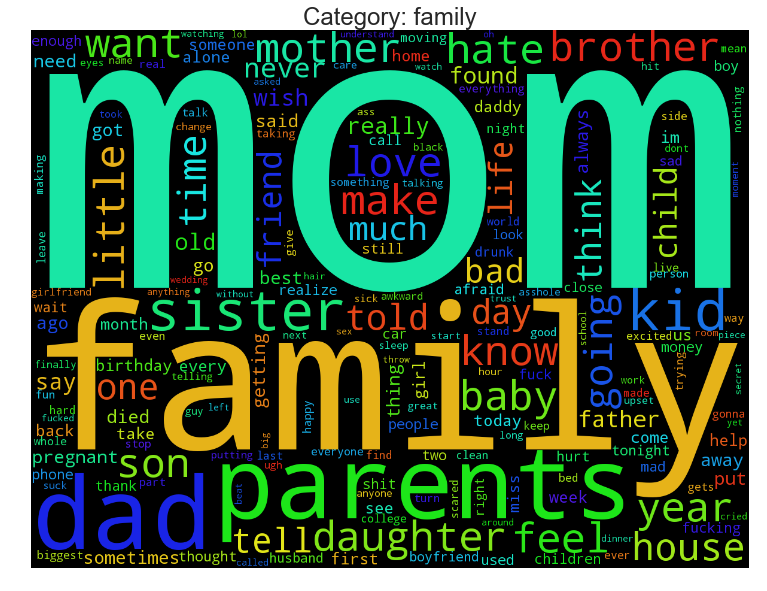

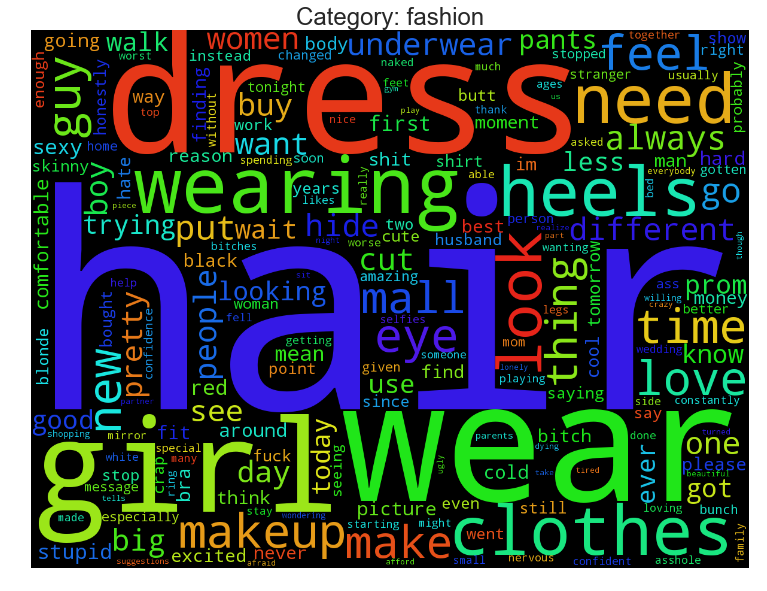

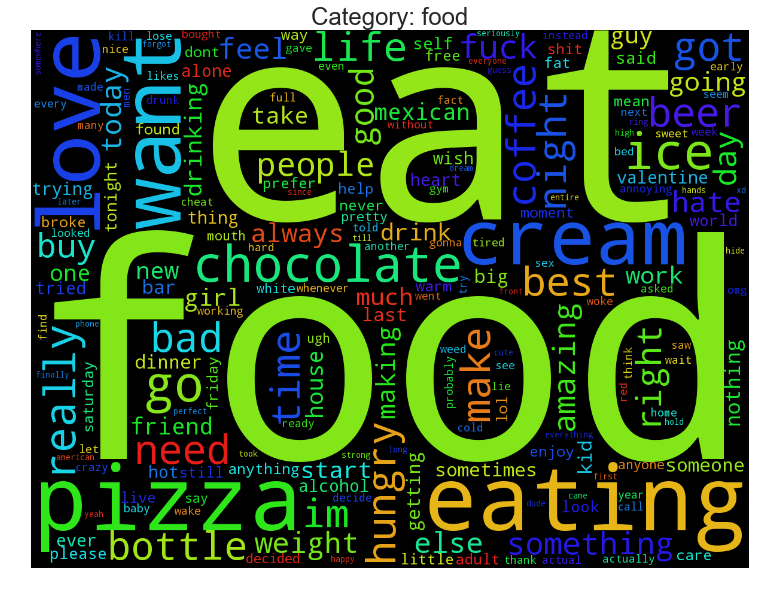

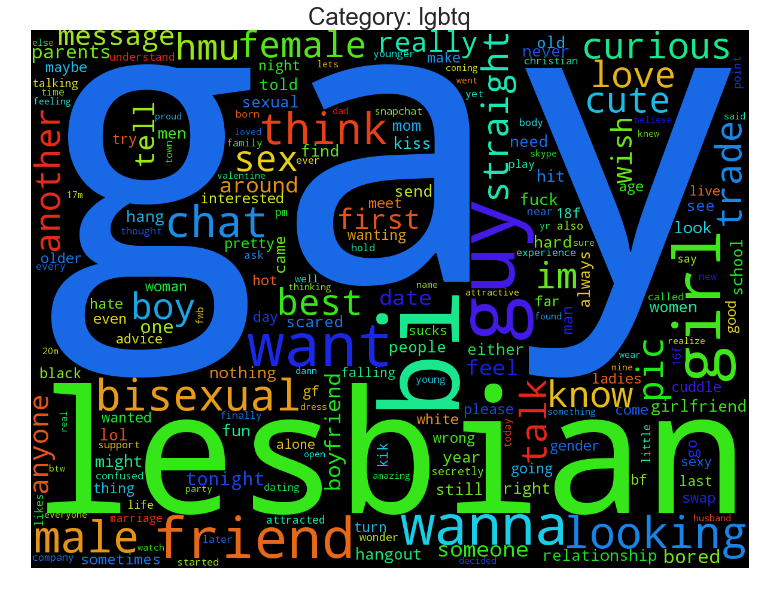

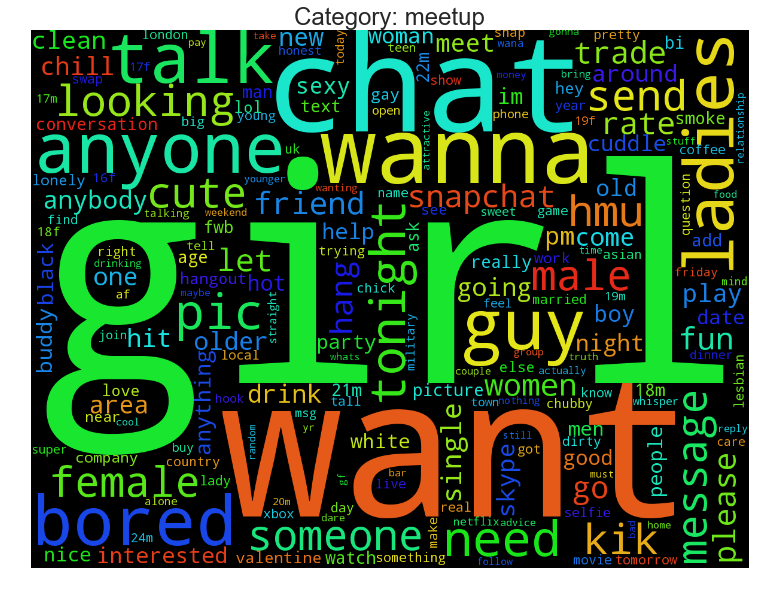

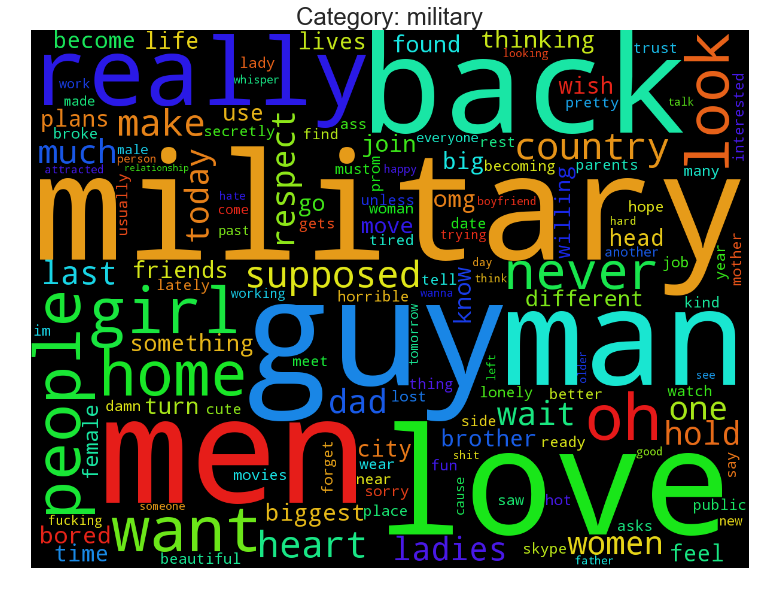

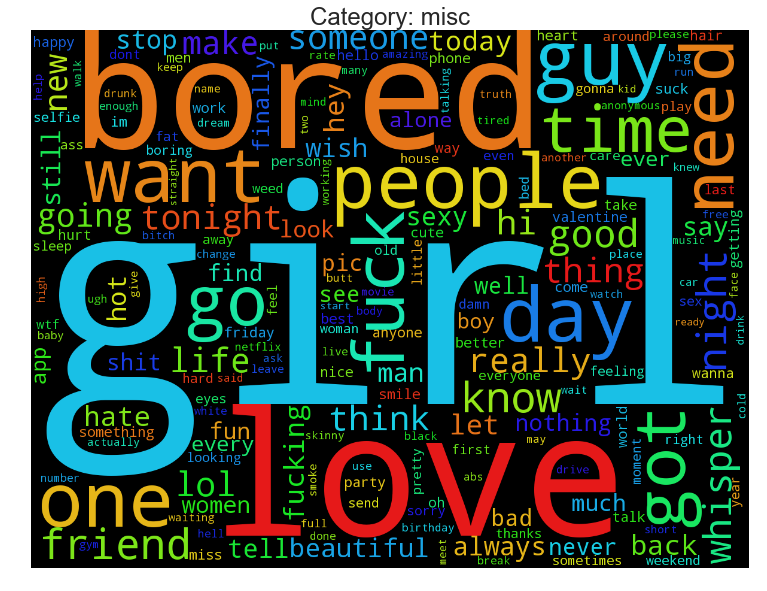

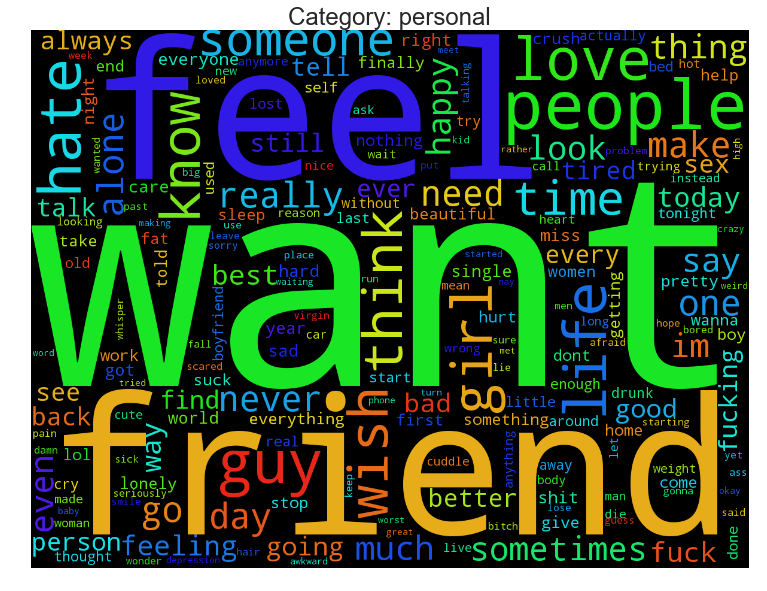

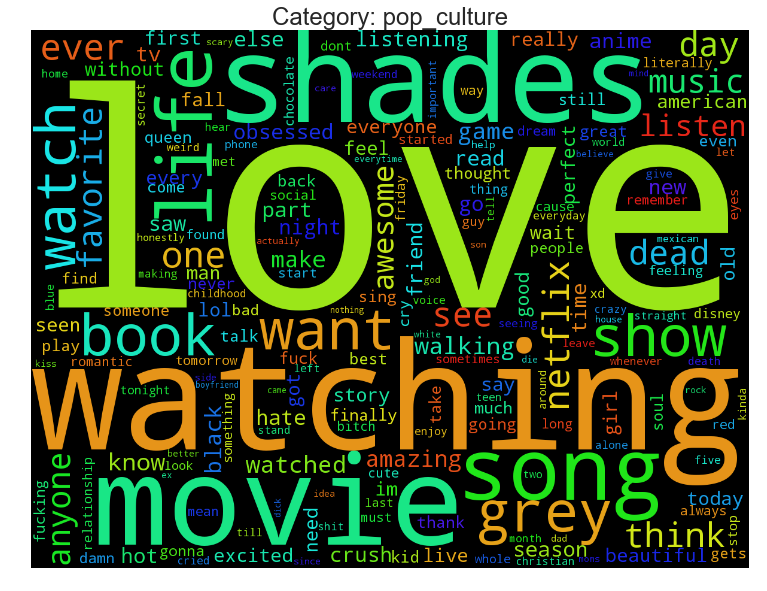

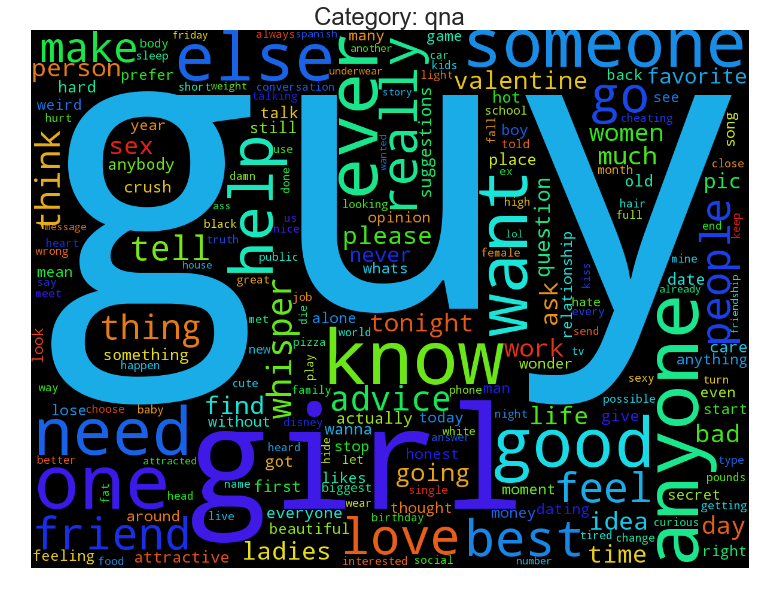

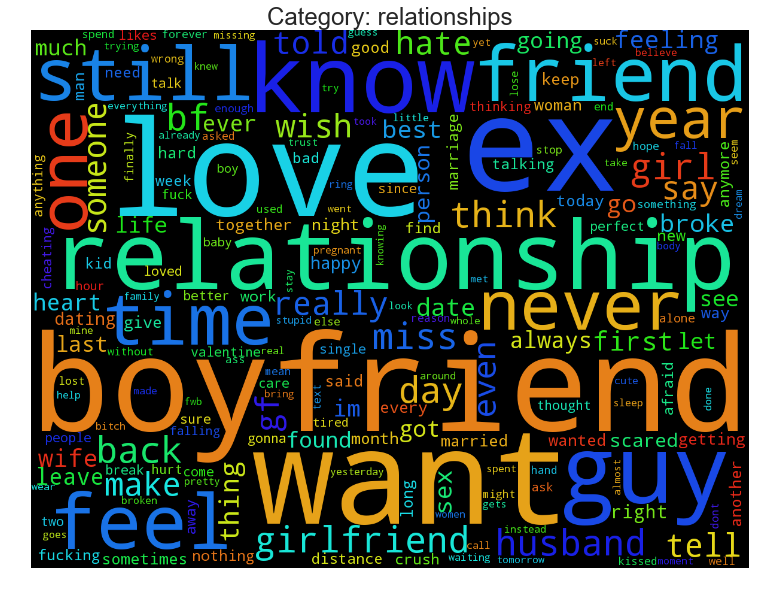

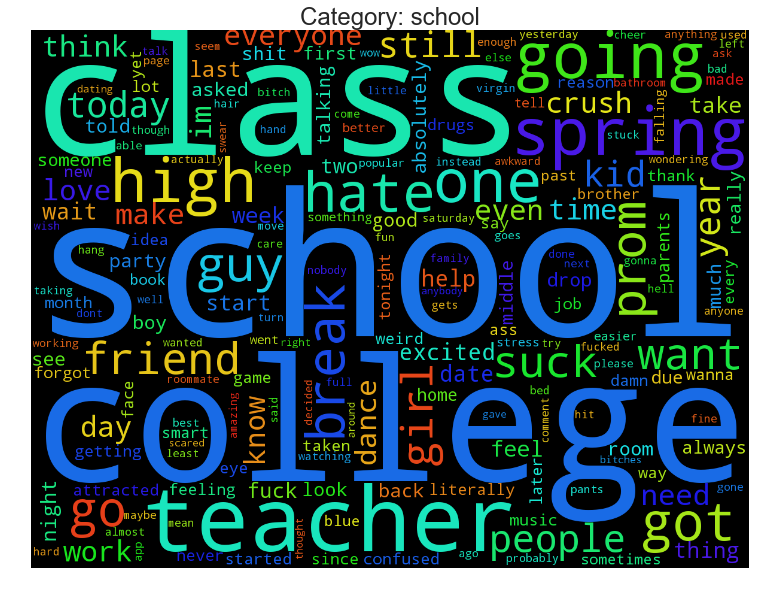

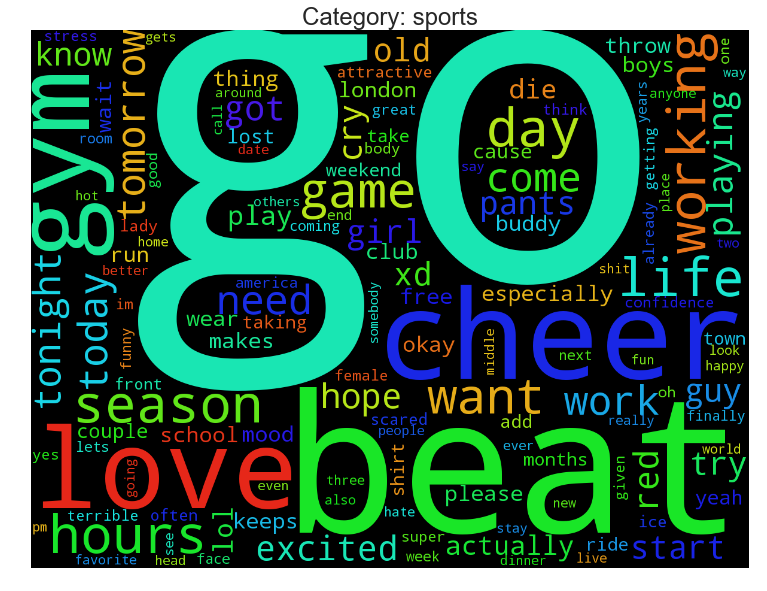

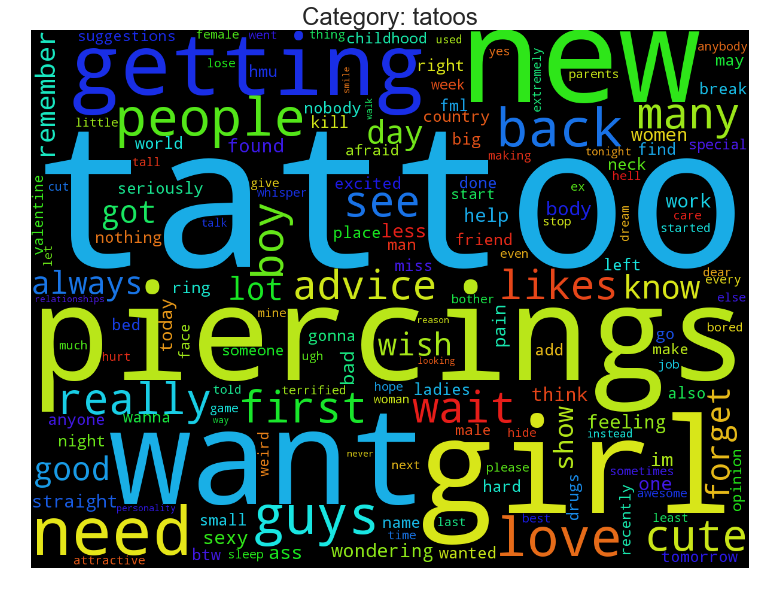

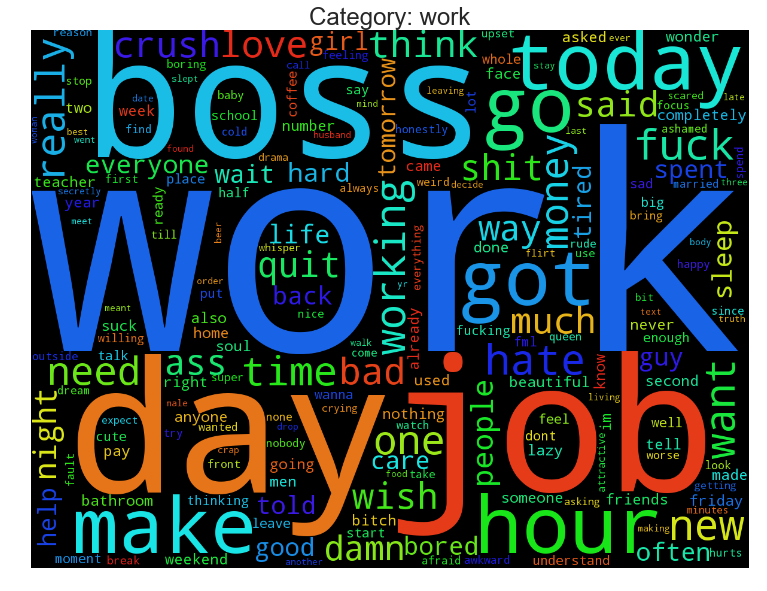

In [11]:
# Wordcloud
from wordcloud import WordCloud

# Plot 
for i in range(tfidf_group.shape[0]):
    words_ = tfidf_group.columns.values[1:]
    weights = tfidf_group.ix[i, 1:].values
    words_weights = zip(words_, weights)
    label = 'Category: ' + tfidf_group.ix[i, 'category']
    words = ' '.join([x[0] for x in words_weights for times in
                     range(0, int(x[1]*1000))]) # https://eradiating.wordpress.com/tag/ipython-notebook/
    wordcloud = WordCloud(background_color='black', 
                          width=1200, 
                          height=900).generate(words)
    
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(label, fontsize = 24)
    plt.tight_layout(pad=0)
    file_name = 'category_' + tfidf_group.ix[i, 'category']
    wordcloud.to_file('wordclouds/'+ file_name + '.png')
    plt.show()

### Experiment-1
- Text cleaning steps (unigrams only)
    - decode
    - lower case
    - tokenize
    - stopword removal
    - stemming
- Models (with 5 fold cross validation):
    - Naive Bayes
    - Decision Tree
    - Random Forest
    - Logistic Regression
    - Support Vector Machine (kernel = linear)

In [12]:
# Imports
import string
from nltk.tokenize import RegexpTokenizer
from nltk import bigrams
from nltk.corpus import stopwords # There may be issue with stopwords (if there is provide a list of stopwords)
from nltk.stem.porter import PorterStemmer


# Function to clean text
def clean_text_1(text):
    '''
    Function to clean text and modify string
    Process: decode > lowercase > tokenize > stopword removal > unigram stemming > join 
        Input: text string
        Output: cleaned and modified text string
    '''
    # RegExp tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # English stopwords
    en_stopwords = stopwords.words('english')
    # English stemmer
    en_stemmer = PorterStemmer()
    
    # Decode: utf-8
    text = text.decode('utf8')
    # Convert text to lower case
    raw_text = text.lower()
    # Tokenize
    tokens = tokenizer.tokenize(raw_text)
    # Remove stopwords: English only
    tokens_remaining = [t for t in tokens if t not in en_stopwords]    
    # Stemming: English only
    tokens_en_stem = [en_stemmer.stem(t) for t in tokens_remaining]   
    # Join unigrams
    cleaned_text = ' '.join(tokens_en_stem)
    return cleaned_text

In [13]:
# Clean text: Experiment-1 
train['text_1'] = train['text'].apply(lambda x: clean_text_1(x))
test['text_1'] = test['text'].apply(lambda x: clean_text_1(x))

In [14]:
# TFIDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# TFIDF vectorizer
vectorizer = TfidfVectorizer(decode_error='replace')

# TFIDF fit and transform: training data
train_tfidf_1 = vectorizer.fit_transform(train['text_1'])
test_tfidf_1 = vectorizer.transform(test['text_1'])
print train_tfidf_1.shape

(14048, 8017)


In [15]:
# Function to evaluate cross-validation
from sklearn.cross_validation import cross_val_score, KFold
from scipy.stats import sem
# sem: standard error of the sample mean is an estimate of how far the sample mean 
#      is likely to be from the population mean

def evaluate_cross_validation(clf, X, y, k):
    # Create a 5 fold cross validation iterator
    cv = KFold(len(y), k, shuffle=True, random_state=15)
    # f1 macro: Calculate metrics for each label, and find their unweighted mean. 
    #           This does not take label imbalance into account.
    scores = cross_val_score(clf, X, y, cv=cv, scoring='f1_macro')
    print scores
    print 'Mean F1 Macro score: {0: 0.3f}(+/-{1: 0.3f})'.format(np.mean(scores), sem(scores))
    
# Pipeline
from sklearn.pipeline import Pipeline

# Models: using default values
# Naive Bayes, Decision Trees, Random Forest,Logistic Regression, SVM (liner)
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.svm import SVC


# Transforms and final estimator
clf_mnb = Pipeline([('vect', TfidfVectorizer()), ('clf', MultinomialNB())])
clf_dt = Pipeline([('vect', TfidfVectorizer()), ('clf', DecisionTreeClassifier(random_state=15))])
clf_rf = Pipeline([('vect', TfidfVectorizer()), ('clf', RandomForestClassifier(random_state=15))])
clf_log_reg = Pipeline([('vect', TfidfVectorizer()), ('clf', linear_model.LogisticRegression())])
clf_svm = Pipeline([('vect', TfidfVectorizer()), ('clf', SVC(kernel='linear'))])

# List of classifiers
# 0. NB, 1. DT, 2. RF, 3. LogReg, 4. SVM
clfs = [clf_mnb, clf_dt, clf_rf, clf_log_reg, clf_svm]

for i, clf in enumerate(clfs):
    print 'Classifier: ', i
    evaluate_cross_validation(clf, train['text_1'], train['category'], 5)

Classifier:  0
[ 0.09427535  0.09505028  0.09569083  0.09526841  0.10290605]
Mean F1 Macro score:  0.097(+/- 0.002)
Classifier:  1
[ 0.36159491  0.35388532  0.39515074  0.36288927  0.38071376]
Mean F1 Macro score:  0.371(+/- 0.007)
Classifier:  2
[ 0.36752036  0.3616153   0.38252915  0.36892148  0.37413103]
Mean F1 Macro score:  0.371(+/- 0.004)
Classifier:  3
[ 0.33588206  0.3312878   0.33839154  0.33127695  0.36232393]
Mean F1 Macro score:  0.340(+/- 0.006)
Classifier:  4
[ 0.46680426  0.46566987  0.48765876  0.4529459   0.44979648]
Mean F1 Macro score:  0.465(+/- 0.007)


In [18]:
# So far the best model is SVM with linear kernel.
# Grid search to tune hyperparameters
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    """
    Function to get best estimator from the GridSearchCV and the best parameter
    Input: 
        clf: an instance of a scikit-learn classifier
        X: training document term matrix (tfidf)
        y: response vector
        n_folds: # of cross validation folds
        score_func: a score function (f1_macro)
    Output:
        Best estimator from the GridSearchCV
        Best parameter
    """
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    
    # Fit the grid search
    gs.fit(X, y)
    best_estimator = gs.best_estimator_
    best_parameter = gs.best_params_
    return (best_estimator, best_parameter)


def classify(clf, parameters, Xtrain, Xtest, ytrain, ytest, n_folds=5, score_func=None):
    if parameters:
        best_clf, best_param = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf = best_clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    testing_accuracy = clf.score(Xtest, ytest)
    print '#####################################################'
    print 'Accuracy on training data: {}'.format(training_accuracy)
    print 'Accuracy on testing data: {}'.format(testing_accuracy)
    print '#####################################################'
    predicted = clf.predict(Xtest)
    testing_f1_macro = f1_score(ytest, predicted, average='macro')
    print 'F1 Score (macro): {}'.format(testing_f1_macro)
    print '#####################################################'
    cm = confusion_matrix(predicted, ytest)
    print 'Confusion Matrix: \n', cm
    print '#####################################################'
    print 'Best Classifier: ', clf
    print 'Best Parameter: ', best_param
    return (predicted, testing_accuracy, testing_f1_macro, best_param, clf, cm)

In [19]:
# Takes a long time to search for optimal regularization parameter (C)
# Large C: Makes constraints hard to ignore -> Narrow margin
# Small C: Allows constraints easy to ignore -> Wide margin
from sklearn.svm import SVC
parameters = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}
predicted, test_accuracy, test_f1_macro, best_parameter, best_classifier, best_cm = classify(SVC(), parameters, train_tfidf_1, test_tfidf_1, train['category'], test['category'], score_func='f1_macro')

#####################################################
Accuracy on training data: 0.608627562642
Accuracy on testing data: 0.543206446235
#####################################################
F1 Score (macro): 0.375956140532
#####################################################
Confusion Matrix: 
[[ 12   0   0   0   0   0   3   0   1   3   0   0   1   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  58   0   0   0   1   0   2   9   2   2   4   2   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0  21   0   3   0   0   1   0   1   1   1   0   0   1]
 [  0   0   0   0   0  86  17   0   1   5   0   2   0   0   0   0   0]
 [  2   0   1   0   0  26 580   1  69  42   4  38  10   1   0   0   1]
 [  0   0   0   0   0   0   0   1   0   0   0   0   1   0   0   0   0]
 [  4   5   7  20  27  11  83   3 378 175  78  74  33  16   6   0   9]
 [  8   6  41  22  15  21  40   9 221 651  55  83 178  30   4   

#### Grid Search uses accuracy score as default to optimize regularization parameter. I provided F1 macro score to optimize regularization parameter. F1 macro score on test data = 0.376 (a slight improvement from baseline case)

In [20]:
from sklearn import metrics

# Predictions
predicted_1 = best_classifier.predict(test_tfidf_1)

# F1 Score (macro)
testing_f1_macro = f1_score(test['category'], predicted_1, average='macro')
print 'F1 Score (macro): {}'.format(testing_f1_macro)
# Accuracy: test data
score = metrics.accuracy_score(test['category'], predicted_1)
print 'Accuracy: {}'.format(score)
# Classification report
print 'Classification Report: \n', metrics.classification_report(test['category'], predicted_1)

F1 Score (macro): 0.375956140532
Accuracy: 0.543206446235
Classification Report: 
             precision    recall  f1-score   support

    animals       0.57      0.46      0.51        26
      faith       0.00      0.00      0.00        11
     family       0.72      0.53      0.61       110
    fashion       0.00      0.00      0.00        42
       food       0.70      0.33      0.45        63
      lgbtq       0.77      0.59      0.67       147
     meetup       0.75      0.79      0.77       737
   military       0.50      0.07      0.12        14
       misc       0.41      0.55      0.47       683
   personal       0.46      0.72      0.56       910
pop_culture       0.67      0.07      0.12       150
        qna       0.55      0.03      0.05       221
relationships       0.78      0.30      0.44       337
     school       0.63      0.30      0.40        74
     sports       0.00      0.00      0.00        10
     tatoos       0.87      0.87      0.87        15
       work   

/Users/ankoorbhagat/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


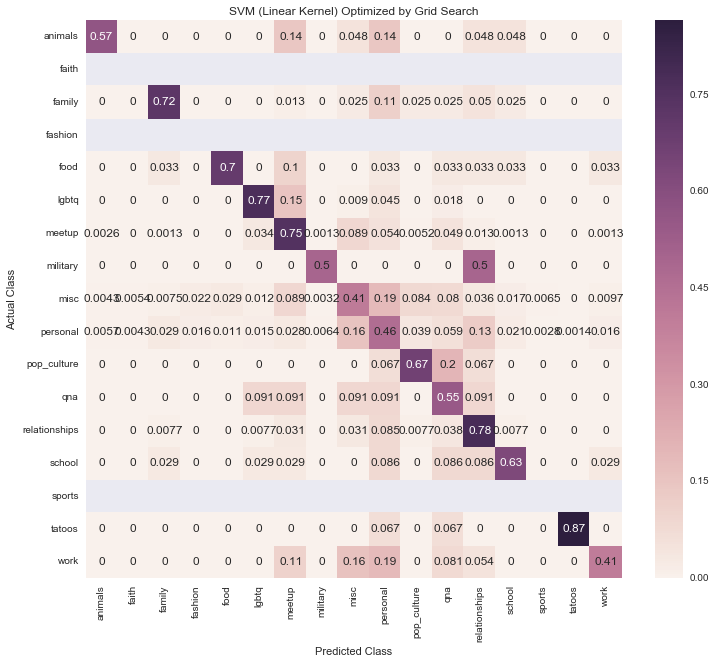

In [21]:
# Function to normalize a matrix
def normalize_mtx(mtx):
    norm_mtx = mtx.astype('float')/mtx.sum(axis=1)[:, np.newaxis]
    return norm_mtx

lab = ['animals', 'faith', 'family', 'fashion', 'food', 'lgbtq', 'meetup',
       'military', 'misc', 'personal', 'pop_culture', 'qna', 'relationships',
       'school', 'sports', 'tatoos', 'work']
plt.figure(figsize = (12, 10))
plt.title('SVM (Linear Kernel) Optimized by Grid Search')
sns.heatmap(normalize_mtx(best_cm), annot=True, xticklabels=lab, yticklabels=lab)
sns.axlabel('Predicted Class', 'Actual Class')

### Experiment-2
- Text cleaning steps (unigrams + bigram)
    - decode
    - lower case
    - tokenize
    - bigram
    - stopword removal from unigrams
    - stemming unigrams
    - join unigrams and bigrams
- tfidf - PCA to reduce dimension
- Models (with 5 fold cross validation):
    - Naive Bayes
    - Decision Tree
    - Random Forest
    - Logistic Regression
    - Support Vector Machine (kernel = linear)

In [22]:
# Function to clean text
def clean_text_2(text):
    '''
    Function to clean text and modify string
    Process: decode > lowercase > tokenize > bigram > stopword removal > unigram stemming > join 
        Input: text string
        Output: cleaned and modified text string
    '''
    # RegExp tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # English stopwords
    en_stopwords = stopwords.words('english')
    # English stemmer
    en_stemmer = PorterStemmer()
    
    # Decode: utf-8
    text = text.decode('utf8')
    # Convert text to lower case
    raw_text = text.lower()
    # Tokenize
    tokens = tokenizer.tokenize(raw_text)
    # Bigrams
    bigram = ['_'.join(bigram) for bigram in bigrams(tokens)]
    # Remove stopwords: English only
    tokens_remaining = [t for t in tokens if t not in en_stopwords]    
    # Stemming: English only
    tokens_en_stem = [en_stemmer.stem(t) for t in tokens_remaining]   
    # Join the tokens (unigrams) and bigram
    cleaned_text = ' '.join(tokens_en_stem + bigram)
    return cleaned_text

In [23]:
# Clean text: Experiment-2 
train['text_2'] = train['text'].apply(lambda x: clean_text_2(x))
test['text_2'] = test['text'].apply(lambda x: clean_text_2(x))

In [24]:
# TFIDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# TFIDF vectorizer
#vectorizer = TfidfVectorizer(decode_error='replace') # Dim: 14048 * 81283

# tfidf vocabulary size is 81283 (HUGE!) -> Slow PCA, use top 10000 tokens
vectorizer = TfidfVectorizer(decode_error='replace', max_features=10000) # Top 10000

# TFIDF fit and transform: training data
train_tfidf_2 = vectorizer.fit_transform(train['text_2'])
test_tfidf_2 = vectorizer.transform(test['text_2'])

print 'tfidf matrix dimension: n = {}, d = {}'.format(train_tfidf_2.shape[0], train_tfidf_2.shape[1])

tfidf matrix dimension: n = 14048, d = 10000


#### Using PCA to reduce tfidf dimension

In [25]:
# Principal Component Analysis: Takes like 30 min on 16 GB ram MacBook Pro
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
std_scaler = StandardScaler()
pca = PCA()

In [26]:
# Standardize (mean=0, var=1)
train_tfidf_2_std = std_scaler.fit_transform(train_tfidf_2.toarray())
train_tfidf_2_pca = pca.fit_transform(train_tfidf_2_std)

In [27]:
# Explained Variance
print 'Explained variance: ', pca.explained_variance_ratio_.sum()

Explained variance:  1.0


In [36]:
# Check the dimensions
print pca.explained_variance_ratio_.shape[0]

# Multiply Explained Variance Ratio with 100 to get %
print pca.explained_variance_ratio_*100

print "First 7000 PC's explain %0.2f percent of data" % (pca.explained_variance_ratio_[:7000].sum() * 100)

10000
[  7.93851493e-02   5.77500236e-02   5.67529636e-02 ...,   5.61605760e-33
   3.41248711e-33   1.89980756e-33]
First 7000 PC's explain 96.33 percent of data


#### Even with 10000 top tokens, PCA was too slow to reduce dimension, as I need to perform cross validation, I decided to test performance of Naive Bayes, Decision Tree, Random Forest, Logistic Regression and SVM (linear) with top 1000 tokens using Experiment-2 text cleaning process (unigram + bigram)

In [74]:
# TFIDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# TFIDF vectorizer
vectorizer = TfidfVectorizer(decode_error='replace', max_features=1000) # Top 1000

# TFIDF fit and transform: training data
train_tfidf_2 = vectorizer.fit_transform(train['text_2'])
test_tfidf_2 = vectorizer.transform(test['text_2'])

print 'tfidf matrix dimension: n = {}, d = {}'.format(train_tfidf_2.shape[0], train_tfidf_2.shape[1])

tfidf matrix dimension: n = 14048, d = 1000


In [103]:
# NOTE: TAKES A VERY LONG TIME! ALMOST GLACIAL

# Principal Component Analysis: Takes like 30 min on 16 GB ram MacBook Pro
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Function to evaluate cross-validation
from sklearn.cross_validation import cross_val_score, KFold
from scipy.stats import sem
# sem: standard error of the sample mean is an estimate of how far the sample mean 
#      is likely to be from the population mean

def evaluate_cross_validation(clf, X, y, k):
    # Create a 5 fold cross validation iterator
    cv = KFold(len(y), k, shuffle=True, random_state=15)
    # f1 macro: Calculate metrics for each label, and find their unweighted mean. 
    #           This does not take label imbalance into account.
    scores = cross_val_score(clf, X, y, cv=cv, scoring='f1_macro')
    print scores
    print 'Mean F1 Macro score: {0: 0.3f}(+/-{1: 0.3f})'.format(np.mean(scores), sem(scores))
    
# Pipeline
from sklearn.pipeline import Pipeline

# Models: using default values
# Naive Bayes, Decision Trees, Random Forest,Logistic Regression, SVM (liner)
#from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.svm import SVC

######################## ---- Sparse to Dense ----- #######################
# Sparse to Dense: http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

class DenseTransformer(TransformerMixin):
    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self


###############################################################################################
#!pip install mlxtend
#from mlxtend.preprocessing import DenseTransformer

# FunctionTransformer: array.todense()
from sklearn.preprocessing import FunctionTransformer

# NOTE: FunctionTransformer and mlxtend.DenseTransformer are not working!
###############################################################################################


# Transforms and final estimator
# clf_mnb = Pipeline([('vect', TfidfVectorizer(max_features=1000)), 
#                     ('dense', DenseTransformer()),
#                     ('std_scaler', StandardScaler()),
#                     #('std_dense', FunctionTransformer(lambda x: x.toarray())),
#                     ('pca', PCA()),
#                     #('clf', MultinomialNB()),
#                     ('clf', GaussianNB())])

clf_dt = Pipeline([('vect', TfidfVectorizer(max_features=1000)),
                    ('dense', DenseTransformer()),
                    ('std_scaler', StandardScaler()),
                    ('pca', PCA()),
                    ('clf', DecisionTreeClassifier(random_state=15))])

clf_rf = Pipeline([('vect', TfidfVectorizer(max_features=1000)), 
                   ('dense', DenseTransformer()),
                   ('std_scaler', StandardScaler()),
                   ('pca', PCA()),
                   ('clf', RandomForestClassifier(random_state=15))])

clf_log_reg = Pipeline([('vect', TfidfVectorizer(max_features=1000)), 
                        ('dense', DenseTransformer()),
                        ('std_scaler', StandardScaler()),
                        ('pca', PCA()),
                        ('clf', linear_model.LogisticRegression())])

clf_svm = Pipeline([('vect', TfidfVectorizer(max_features=1000)),
                    ('dense', DenseTransformer()),
                    ('std_scaler', StandardScaler()),
                    ('pca', PCA()),
                    ('clf', SVC(kernel='linear'))])

# List of classifiers: NB does not work with Negative Values in matrix!
# 0. NB, 1. DT, 2. RF, 3. LogReg, 4. SVM
#clfs = [clf_mnb, clf_dt, clf_rf, clf_log_reg, clf_svm]

# 0. DT, 1. RF, 2. LogReg, 3. SVM
clfs = [clf_dt, clf_rf, clf_log_reg, clf_svm]


for i, clf in enumerate(clfs):
    print 'Classifier: ', i
    evaluate_cross_validation(clf, train['text_2'], train['category'], 5)

Classifier:  0
[ 0.16334945  0.15170998  0.17902615  0.1603311   0.16154156]
Mean F1 Macro score:  0.163(+/- 0.004)
Classifier:  1
[ 0.16213663  0.13560057  0.18150646  0.14737299  0.15992803]
Mean F1 Macro score:  0.157(+/- 0.008)
Classifier:  2
[ 0.37873399  0.38060856  0.3948947   0.34639246  0.37047828]
Mean F1 Macro score:  0.374(+/- 0.008)
Classifier:  3
[ 0.36576201  0.35121145  0.39404181  0.32725505  0.38611224]
Mean F1 Macro score:  0.365(+/- 0.012)


#### Experiment-2 is taking too long so decided to focus on Word2Vec, Neural Network and Convolutional Neural Network

In [ ]:
# So far the best model is SVM with linear kernel.
# Grid search to tune hyperparameters
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

def cv_optimize(clf, parameters, X, y, n_folds=3, score_func=None):
    """
    Function to get best estimator from the GridSearchCV and the best parameter
    Input: 
        clf: an instance of a scikit-learn classifier
        X: training document term matrix (tfidf)
        y: response vector
        n_folds: # of cross validation folds
        score_func: a score function (f1_macro)
    Output:
        Best estimator from the GridSearchCV
        Best parameter
    """
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    
    # Fit the grid search
    gs.fit(X, y)
    best_estimator = gs.best_estimator_
    best_parameter = gs.best_params_
    return (best_estimator, best_parameter)


def classify(clf, parameters, Xtrain, Xtest, ytrain, ytest, n_folds=5, score_func=None):
    if parameters:
        best_clf, best_param = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf = best_clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    testing_accuracy = clf.score(Xtest, ytest)
    print '#####################################################'
    print 'Accuracy on training data: {}'.format(training_accuracy)
    print 'Accuracy on testing data: {}'.format(testing_accuracy)
    print '#####################################################'
    predicted = clf.predict(Xtest)
    testing_f1_macro = f1_score(ytest, predicted, average='macro')
    print 'F1 Score (macro): {}'.format(testing_f1_macro)
    print '#####################################################'
    cm = confusion_matrix(predicted, ytest)
    print 'Confusion Matrix: \n', cm
    print '#####################################################'
    print 'Best Classifier: ', clf
    print 'Best Parameter: ', best_param
    return (predicted, testing_accuracy, testing_f1_macro, best_param, clf, cm)

In [ ]:
# Grid search: hyperparameter optimization
estimators = [('vect', TfidfVectorizer(max_features=1000)),
              ('dense', DenseTransformer()),
              ('std_scaler', StandardScaler()),
              ('pca', PCA()),
              ('clf', SVC(kernel='linear'))]

clf = Pipeline(estimators)

# Takes a long time to search for optimal regularization parameter (C)
# Large C: Makes constraints hard to ignore -> Narrow margin
# Small C: Allows constraints easy to ignore -> Wide margin
from sklearn.svm import SVC
parameters = {"C": [0.001, 1.0, 1000.0]}
predicted, test_accuracy, test_f1_macro, best_parameter, best_classifier, best_cm = classify(clf, parameters, train['text_2'], test['text_2'], train['category'], test['category'], score_func='f1_macro')

In [ ]:
from sklearn import metrics

# Predictions
predicted_2 = best_classifier.predict(test_tfidf_2)

# F1 Score (macro)
testing_f1_macro = f1_score(test['category'], predicted_2, average='macro')
print 'F1 Score (macro): {}'.format(testing_f1_macro)
# Accuracy: test data
score = metrics.accuracy_score(test['category'], predicted_1)
print 'Accuracy: {}'.format(score)
# Classification report
print 'Classification Report: \n', metrics.classification_report(test['category'], predicted_1)

In [ ]:
# Function to normalize a matrix
def normalize_mtx(mtx):
    norm_mtx = mtx.astype('float')/mtx.sum(axis=1)[:, np.newaxis]
    return norm_mtx

lab = ['animals', 'faith', 'family', 'fashion', 'food', 'lgbtq', 'meetup',
       'military', 'misc', 'personal', 'pop_culture', 'qna', 'relationships',
       'school', 'sports', 'tatoos', 'work']
plt.figure(figsize = (12, 10))
plt.title('SVM (Linear Kernel) Optimized by Grid Search')
sns.heatmap(normalize_mtx(best_cm), annot=True, xticklabels=lab, yticklabels=lab)
sns.axlabel('Predicted Class', 'Actual Class')

### Experiment-3 
- Text cleaning
- Word2Vec (average of word vectors in a paragraph)
    - Continuous Bag of Words (CBOW) is faster
    - Skipgram is slower 
- Models (with 5 fold cross validation):
    - Decision Tree
    - Random Forest
    - Logistic Regression
    - Support Vector Machine (kernel = linear)

In [121]:
# Imports
from nltk.tokenize import RegexpTokenizer

# Function to clean text
def clean_text_w2v(text):
    '''
    Function to clean text and modify string
    Process: decode > lowercase >  tokenize 
        Input: text string
        Output: cleaned and modified text string
    '''
    # Decode: utf-8
    text = text.decode('utf8')
    # RegExp tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # Convert text to lower case
    raw_text = text.lower()
    # Tokenize
    tokens = tokenizer.tokenize(raw_text)    
    return tokens

In [122]:
# Clean the training and testing texts
train_clean_X = []
for i in xrange(train.shape[0]):
    temp = train['text'].ix[i]
    train_clean_X.append(clean_text_w2v(temp))
    
test_clean_X = []
for i in xrange(test.shape[0]):
    temp = test['text'].ix[i]
    test_clean_X.append(clean_text_w2v(temp))

In [123]:
# Multiprocessing
from multiprocessing import cpu_count

# Gensim
from gensim.models.word2vec import Word2Vec

In [124]:
# Model: 
#       size = 300 as per http://arxiv.org/pdf/1408.5882v2.pdf
#       window = 5 max distance between the current and predicted word within a sentence.
#       min_count` = 10 (ignore all words with total frequency lower than this.)
#       sg = 0 (use CBOW)

# Initiate model
num_features = 300
model = Word2Vec(size=num_features, window=5, min_count=10, sg=0, workers=cpu_count())

# Build vocabulary using training data
model.build_vocab(train_clean_X)

# Train using training data and save model
model.train(train_clean_X)
model.save('w2v/train')

# Feature vector of each word in vocabulary
print "Vocabulary: {} words".format(model.syn0.shape[0])
print "Word Vector length (# of features): ", model.syn0.shape[1]

Vocabulary: 1537 words
Word Vector length (# of features):  300


In [125]:
def buildWordVector(text, model, size):
    '''
    Function to average all of word vectors in a given paragraph
    https://districtdatalabs.silvrback.com/modern-methods-for-sentiment-analysis
    '''
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in text:
        try:
            vec += model[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

def average_feature_vecs(docs, model, num_features):
    '''
    Given a set of documents (each document is a list of words), calculate
    the average feature vector for each one and return a numpy 2d array
    '''
    # Initialize a counter
    counter = 0
    
    # Pre-initialize an empty 2D numpy array for speed
    doc_feature_vecs = np.zeros((len(docs), num_features), dtype="float32")
    
    # Loop through the documents and get average feature vec
    for doc in docs:
        # Call make feature vector function
        doc_feature_vecs[counter] = buildWordVector(doc, model, num_features)
        # Increment the counter
        counter = counter + 1
    return doc_feature_vecs

In [126]:
# Get average feature vector: training dataset
train_doc_vecs = average_feature_vecs(train_clean_X, model, num_features)

# Scale data: Center to the mean and component wise scale to unit variance
from sklearn.preprocessing import scale
train_doc_vecs = scale(train_doc_vecs)
print train_doc_vecs.shape

(14048, 300)


In [127]:
# Train using testing data and save model
model.train(test_clean_X)
model.save('w2v/test')

# Get average feature vector
test_doc_vecs = average_feature_vecs(test_clean_X, model, num_features)

# Scale data: Center to the mean and component wise scale to unit variance
from sklearn.preprocessing import scale
test_doc_vecs = scale(test_doc_vecs)
print test_doc_vecs.shape

(3599, 300)


In [129]:
# Function to evaluate cross-validation: Takes long time for SVM
from sklearn.cross_validation import cross_val_score, KFold
from scipy.stats import sem
# sem: standard error of the sample mean is an estimate of how far the sample mean 
#      is likely to be from the population mean

def evaluate_cross_validation(clf, X, y, k):
    # Create a 5 fold cross validation iterator
    cv = KFold(len(y), k, shuffle=True, random_state=15)
    # f1 macro: Calculate metrics for each label, and find their unweighted mean. 
    #           This does not take label imbalance into account.
    scores = cross_val_score(clf, X, y, cv=cv, scoring='f1_macro')
    print scores
    print 'Mean F1 Macro score: {0: 0.3f}(+/-{1: 0.3f})'.format(np.mean(scores), sem(scores))
    
# Pipeline
from sklearn.pipeline import Pipeline

# Models: using default values
# Decision Trees, Random Forest,Logistic Regression, SVM (liner)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.svm import SVC


# Transforms and final estimator
clf_dt = Pipeline([('clf', DecisionTreeClassifier(random_state=15))])
clf_rf = Pipeline([('clf', RandomForestClassifier(random_state=15))])
clf_log_reg = Pipeline([('clf', linear_model.LogisticRegression())])
clf_svm = Pipeline([('clf', SVC(kernel='linear'))])

# List of classifiers
# 0. DT, 1. RF, 2. LogReg, 3. SVM
clfs = [clf_dt, clf_rf, clf_log_reg, clf_svm]

for i, clf in enumerate(clfs):
    print 'Classifier: ', i
    evaluate_cross_validation(clf, train_doc_vecs, train['category'], 5)

Classifier:  0
[ 0.13761246  0.13134456  0.14035265  0.13525902  0.1414476 ]
Mean F1 Macro score:  0.137(+/- 0.002)
Classifier:  1
[ 0.14874446  0.14805989  0.16086205  0.15457695  0.16511072]
Mean F1 Macro score:  0.155(+/- 0.003)
Classifier:  2
[ 0.15733197  0.14851634  0.14772006  0.15305056  0.14495176]
Mean F1 Macro score:  0.150(+/- 0.002)
Classifier:  3
[ 0.15077377  0.14872888  0.14580833  0.1466264   0.14814318]
Mean F1 Macro score:  0.148(+/- 0.001)


### Experiment failed. All the mean F1 Macro score are worse than baseline F1 macro score!